In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from pathlib import Path


# Build robust path to data folder (notebooks and data are siblings)
DATA_DIR = Path.cwd().parent / 'data'
SUB_DIR = Path.cwd().parent / 'submissions'
train_path = DATA_DIR / 'train.csv'
test_path = DATA_DIR / 'test.csv'


# Load the datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)  # This is for final predictions (no 'W' column)

# Display basic information about the datasets
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"'W' column in train dataset: {'W' in train_df.columns}")
print(f"'W' column in test dataset: {'W' in test_df.columns}")

Training set shape: (1812, 51)
Test set shape: (453, 45)
'W' column in train dataset: True
'W' column in test dataset: False


In [2]:
# Create derived features for both train and test sets

# R_per_game: Runs per game
# RA_per_game: Runs allowed per game
train_df['R_per_game'] = train_df['R'] / train_df['G']
train_df['RA_per_game'] = train_df['RA'] / train_df['G']
test_df['R_per_game'] = test_df['R'] / test_df['G']
test_df['RA_per_game'] = test_df['RA'] / test_df['G']

print(f"\nCreated derived features: R_per_game, RA_per_game")
print(f"Train - R_per_game range: {train_df['R_per_game'].min():.3f} to {train_df['R_per_game'].max():.3f}")
print(f"Train - RA_per_game range: {train_df['RA_per_game'].min():.3f} to {train_df['RA_per_game'].max():.3f}")
print(f"Test - R_per_game range: {test_df['R_per_game'].min():.3f} to {test_df['R_per_game'].max():.3f}")
print(f"Test - RA_per_game range: {test_df['RA_per_game'].min():.3f} to {test_df['RA_per_game'].max():.3f}")

# Expected Wins of Season = G × (R²) / (R² + RA²)
train_df['Expected_Wins'] = train_df['G'] * (train_df['R_per_game'] ** 2) / ((train_df['R_per_game'] ** 2) + (train_df['RA_per_game'] ** 2))
test_df['Expected_Wins'] = test_df['G'] * (test_df['R_per_game'] ** 2) / ((test_df['R_per_game'] ** 2) + (test_df['RA_per_game'] ** 2))
# train_df['Expected_Wins'] = train_df['G'] * (train_df['R'] ** 2) / ((train_df['R'] ** 2) + (train_df['RA'] ** 2))
# test_df['Expected_Wins'] = test_df['G'] * (test_df['R'] ** 2) / ((test_df['R'] ** 2) + (test_df['RA'] ** 2))
print(f"\nCreated derived feature: Expected_Wins")   
print(f"Train - Expected_Wins range: {train_df['Expected_Wins'].min():.3f} to {train_df['Expected_Wins'].max():.3f}")
print(f"Test - Expected_Wins range: {test_df['Expected_Wins'].min():.3f} to {test_df['Expected_Wins'].max():.3f}")

# Times getting on base
train_df['Times_On_Base'] = train_df['H'] + train_df['BB']
test_df['Times_On_Base'] = test_df['H'] + test_df['BB']

print(f"\nCreated derived feature: Times_On_Base")
print(f"Train - Times_On_Base range: {train_df['Times_On_Base'].min():.3f} to {train_df['Times_On_Base'].max():.3f}")
print(f"Test - Times_On_Base range: {test_df['Times_On_Base'].min():.3f} to {test_df['Times_On_Base'].max():.3f}")

# BB Rate (Walk Percentage) - BB / AB + BB
train_df['BB_Rate'] = train_df['BB'] / (train_df['AB'] + train_df['BB'])
test_df['BB_Rate'] = test_df['BB'] / (test_df['AB'] + test_df['BB'])

print(f"\nCreated derived feature: BB_Rate")
print(f"Train - BB_Rate range: {train_df['BB_Rate'].min():.3f} to {train_df['BB_Rate'].max():.3f}") 
print(f"Test - BB_Rate range: {test_df['BB_Rate'].min():.3f} to {test_df['BB_Rate'].max():.3f}")

# Home Run Rate - HR / AB
train_df['HR_Rate'] = train_df['HR'] / train_df['AB']
test_df['HR_Rate'] = test_df['HR'] / test_df['AB']

print(f"\nCreated derived feature: HR_Rate")
print(f"Train - HR_Rate range: {train_df['HR_Rate'].min():.3f} to {train_df['HR_Rate'].max():.3f}")
print(f"Test - HR_Rate range: {test_df['HR_Rate'].min():.3f} to {test_df['HR_Rate'].max():.3f}")

# On-Base Percentage (OBP) - (H + BB) / (AB + BB)
train_df['OBP'] = (train_df['H'] + train_df['BB']) / (train_df['AB'] + train_df['BB'])
test_df['OBP'] = (test_df['H'] + test_df['BB']) / (test_df['AB'] + test_df['BB'])

print(f"\nCreated derived feature: OBP")
print(f"Train - OBP range: {train_df['OBP'].min():.3f} to {train_df['OBP'].max():.3f}") 
print(f"Test - OBP range: {test_df['OBP'].min():.3f} to {test_df['OBP'].max():.3f}")

# Slugging Percentage (SLG)
# Singles = H - (2B + 3B + HR)
# Total Bases = Singles + (2 * 2B) + (3 * 3B) + (4 * HR)
# SLG = Total Bases / AB
Singles_train = train_df['H'] - (train_df['2B'] + train_df['3B'] + train_df['HR'])
Total_Bases_train = Singles_train + (2 * train_df['2B']) + (3 * train_df['3B']) + (4 * train_df['HR'])
train_df['SLG'] = Total_Bases_train / train_df['AB']  

Singles_test = test_df['H'] - (test_df['2B'] + test_df['3B'] + test_df['HR'])
Total_Bases_test = Singles_test + (2 * test_df['2B']) + (3 * test_df['3B']) + (4 * test_df['HR'])
test_df['SLG'] = Total_Bases_test / test_df['AB']

print(f"\nCreated derived feature: SLG")
print(f"Train - SLG range: {train_df['SLG'].min():.3f} to {train_df['SLG'].max():.3f}") 
print(f"Test - SLG range: {test_df['SLG'].min():.3f} to {test_df['SLG'].max():.3f}")    

# Combined On-Base Plus Slugging (OPS) - OBP + SLG
train_df['OPS'] = train_df['OBP'] + train_df['SLG']
test_df['OPS'] = test_df['OBP'] + test_df['SLG']

print(f"\nCreated derived feature: OPS")
print(f"Train - OPS range: {train_df['OPS'].min():.3f} to {train_df['OPS'].max():.3f}") 
print(f"Test - OPS range: {test_df['OPS'].min():.3f} to {test_df['OPS'].max():.3f}")

# Time on Base Allowed - HA + BBA
train_df['Times_On_Base_Allowed'] = train_df['HA'] + train_df['BBA']
test_df['Times_On_Base_Allowed'] = test_df['HA'] + test_df['BBA']

print(f"\nCreated derived feature: Times_On_Base_Allowed")
print(f"Train - Times_On_Base_Allowed range: {train_df['Times_On_Base_Allowed'].min():.3f} to {train_df['Times_On_Base_Allowed'].max():.3f}")
print(f"Test - Times_On_Base_Allowed range: {test_df['Times_On_Base_Allowed'].min():.3f} to {test_df['Times_On_Base_Allowed'].max():.3f}")

# WHIP (Walks plus Hits per Inning Pitched)
# Inings Pitched = IPouts / 3
# Times_On_Base_Per_Inning = Times_On_Base_Allowed / Inings_Pitched
train_df['Innings_Pitched'] = train_df['IPouts'] / 3
train_df['WHIP'] = train_df['Times_On_Base_Allowed'] / train_df['Innings_Pitched']
test_df['Innings_Pitched'] = test_df['IPouts'] / 3
test_df['WHIP'] = test_df['Times_On_Base_Allowed'] / test_df['Innings_Pitched']

print(f"\nCreated derived feature: WHIP")
print(f"Train - WHIP range: {train_df['WHIP'].min():.3f} to {train_df['WHIP'].max():.3f}")
print(f"Test - WHIP range: {test_df['WHIP'].min():.3f} to {test_df['WHIP'].max():.3f}")

# K/9 (Strikeouts per 9 Innings) - SOA / Innings_Pitched * 9
train_df['K_per_9'] = (train_df['SOA'] / train_df['Innings_Pitched']) * 9
test_df['K_per_9'] = (test_df['SOA'] / test_df['Innings_Pitched']) * 9  

print(f"\nCreated derived feature: K_per_9")
print(f"Train - K_per_9 range: {train_df['K_per_9'].min():.3f} to {train_df['K_per_9'].max():.3f}")
print(f"Test - K_per_9 range: {test_df['K_per_9'].min():.3f} to {test_df['K_per_9'].max():.3f}")

# HR/9 (Home Runs Allowed per 9 Innings) - HRA / Innings_Pitched * 9
train_df['HR_per_9'] = (train_df['HRA'] / train_df['Innings_Pitched']) * 9
test_df['HR_per_9'] = (test_df['HRA'] / test_df['Innings_Pitched']) * 9

print(f"\nCreated derived feature: HR_per_9")
print(f"Train - HR_per_9 range: {train_df['HR_per_9'].min():.3f} to {train_df['HR_per_9'].max():.3f}")
print(f"Test - HR_per_9 range: {test_df['HR_per_9'].min():.3f} to {test_df['HR_per_9'].max():.3f}")



Created derived features: R_per_game, RA_per_game
Train - R_per_game range: 2.409 to 6.884
Train - RA_per_game range: 2.458 to 7.686
Test - R_per_game range: 2.783 to 6.896
Test - RA_per_game range: 2.867 to 6.865

Created derived feature: Expected_Wins
Train - Expected_Wins range: 35.860 to 119.963
Test - Expected_Wins range: 40.352 to 107.111

Created derived feature: Times_On_Base
Train - Times_On_Base range: 1367.000 to 2415.000
Test - Times_On_Base range: 1453.000 to 2327.000

Created derived feature: BB_Rate
Train - BB_Rate range: 0.051 to 0.136
Test - BB_Rate range: 0.052 to 0.123

Created derived feature: HR_Rate
Train - HR_Rate range: 0.001 to 0.047
Test - HR_Rate range: 0.001 to 0.045

Created derived feature: OBP
Train - OBP range: 0.262 to 0.382
Test - OBP range: 0.267 to 0.382

Created derived feature: SLG
Train - SLG range: 0.274 to 0.491
Test - SLG range: 0.261 to 0.488

Created derived feature: OPS
Train - OPS range: 0.539 to 0.870
Test - OPS range: 0.530 to 0.870

Cre

In [3]:
# Select only the default features from DATA_DESCRIPTION.md
# default_features = [
#     # Basic Statistics
#     'G', 'HR', 'SHO', 'SV', 'IPouts', 'FP', 'ERA', 'ER', 'E',

#     # Derived Features
#     'Expected_Wins', 'Times_On_Base', 'BB_Rate', 'HR_Rate', 'OPS', 'Times_On_Base_Allowed', 
#     'WHIP', 'K_per_9', 'HR_per_9', 'mlb_rpg',
    
#     # Era Indicators
#     'era_1', 'era_2', 'era_3', 'era_4', 'era_5', 'era_6', 'era_7', 'era_8',
    
#     # Decade Indicators
#     'decade_1910', 'decade_1920', 'decade_1930', 'decade_1940', 'decade_1950',
#     'decade_1960', 'decade_1970', 'decade_1980', 'decade_1990', 'decade_2000', 'decade_2010'
# ]

default_features = [
    # Basic Statistics
    'G', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF',
    'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA',
    'E', 'DP', 'FP', 'attendance', 'BPF', 'PPF',
    
    # Derived Features
    'Expected_Wins', 'Times_On_Base', 'BB_Rate', 'HR_Rate', 'OPS', 'Times_On_Base_Allowed', 
    'WHIP', 'K_per_9', 'HR_per_9', 'mlb_rpg',
    
    # Era Indicators
    'era_1', 'era_2', 'era_3', 'era_4', 'era_5', 'era_6', 'era_7', 'era_8',
    
    # Decade Indicators
    'decade_1910', 'decade_1920', 'decade_1930', 'decade_1940', 'decade_1950',
    'decade_1960', 'decade_1970', 'decade_1980', 'decade_1990', 'decade_2000', 'decade_2010'
 ]

# Filter features that exist in both training data AND test data
available_features = [col for col in default_features 
                     if col in train_df.columns and col in test_df.columns]
print(f"Number of available default features: {len(available_features)}")

# Print available features in a column
print("Available features:")
for feature in available_features:
    print(feature)


Number of available default features: 53
Available features:
G
R
AB
H
2B
3B
HR
BB
SO
SB
RA
ER
ERA
CG
SHO
SV
IPouts
HA
HRA
BBA
SOA
E
DP
FP
Expected_Wins
Times_On_Base
BB_Rate
HR_Rate
OPS
Times_On_Base_Allowed
WHIP
K_per_9
HR_per_9
mlb_rpg
era_1
era_2
era_3
era_4
era_5
era_6
era_7
era_8
decade_1910
decade_1920
decade_1930
decade_1940
decade_1950
decade_1960
decade_1970
decade_1980
decade_1990
decade_2000
decade_2010


In [4]:
# Prepare training data (split the train.csv for model evaluation)
X_full = train_df[available_features]
y_full = train_df['W']

# Split training data into train/validation sets for model evaluation
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

# Prepare final test data for predictions (this has no target variable)
X_test_final = test_df[available_features]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Final test set shape: {X_test_final.shape}")

Training set shape: (1449, 53)
Validation set shape: (363, 53)
Final test set shape: (453, 53)


In [5]:
# Import boosting libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_validate
import time
import warnings

# Silence XGBoost FutureWarnings about deprecated pandas functions
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

print("BOOSTING MODELS COMPARISON")
print("="*50)

# Prepare data
X = X_full
y = y_full

print(f"\nDataset shape: {X.shape}")
print(f"Features being used: {list(X.columns)}")

# Define models with GPU acceleration where available
models = {
    'XGBoost': XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0,
        tree_method="hist",
        device="cuda"  # 🚀 GPU acceleration 
    ),
    
    'LightGBM': LGBMRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1,
        device='cuda'  # 🚀 GPU acceleration 
    ),
    
    'CatBoost': CatBoostRegressor(
        iterations=200,
        depth=6,
        learning_rate=0.1,
        random_seed=42,
        verbose=False,
        task_type="GPU"  # 🚀 GPU acceleration 
    )
}

# Cross-validation
cv_results = {}

for name, model in models.items():
    print(f"\nTesting {name}...")
    start_time = time.time()
    
    try:
        # Get both R² and MAE
        cv_scores = cross_validate(
            model, X, y, 
            cv=5, 
            scoring=['r2', 'neg_mean_absolute_error'],
            return_train_score=True,
            verbose=0
        )
        
        end_time = time.time()
        
        cv_results[name] = {
            'test_r2': cv_scores['test_r2'].mean(),
            'test_r2_std': cv_scores['test_r2'].std(),
            'test_mae': -cv_scores['test_neg_mean_absolute_error'].mean(),
            'test_mae_std': cv_scores['test_neg_mean_absolute_error'].std(),
            'train_r2': cv_scores['train_r2'].mean(),
            'overfitting': cv_scores['train_r2'].mean() - cv_scores['test_r2'].mean(),
            'time': end_time - start_time,
            'gpu_status': '✅ GPU'
        }
        
    except Exception as e:
        print(f"   ⚠️ GPU failed, falling back to CPU: {str(e)}")
        # Fallback to CPU version
        if name == 'XGBoost':
            model.set_params(device="cpu")
        elif name == 'LightGBM':
            model.set_params(device="cpu")
        elif name == 'CatBoost':
            model.set_params(task_type="CPU")
            
        cv_scores = cross_validate(
            model, X, y, 
            cv=5, 
            scoring=['r2', 'neg_mean_absolute_error'],
            return_train_score=True,
            verbose=0
        )
        
        end_time = time.time()
        
        cv_results[name] = {
            'test_r2': cv_scores['test_r2'].mean(),
            'test_r2_std': cv_scores['test_r2'].std(),
            'test_mae': -cv_scores['test_neg_mean_absolute_error'].mean(),
            'test_mae_std': cv_scores['test_neg_mean_absolute_error'].std(),
            'train_r2': cv_scores['train_r2'].mean(),
            'overfitting': cv_scores['train_r2'].mean() - cv_scores['test_r2'].mean(),
            'time': end_time - start_time,
            'gpu_status': '⚠️ CPU fallback'
        }

# Display results
print(f"\n{'Model':<12} {'Test R²':<10} {'Test MAE':<10} {'Overfitting':<12} {'Time (s)':<10} {'GPU Status':<15}")
print("-" * 90)

for name, results in sorted(cv_results.items(), key=lambda x: x[1]['test_r2'], reverse=True):
    print(f"{name:<12} {results['test_r2']:.4f}    {results['test_mae']:.2f}      {results['overfitting']:.4f}      {results['time']:.1f}      {results['gpu_status']}")

# Feature importance for best model
best_model_name = max(cv_results.keys(), key=lambda x: cv_results[x]['test_r2'])
best_model = models[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"Training {best_model_name} on full dataset for feature importance...")

best_model.fit(X, y)

# Get feature importance
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 15 Features from {best_model_name}:")
    print("-" * 40)
    for i, row in importance_df.head(15).iterrows():
        print(f"{row['feature']:>20}: {row['importance']:.4f}")


BOOSTING MODELS COMPARISON

Dataset shape: (1812, 53)
Features being used: ['G', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'Expected_Wins', 'Times_On_Base', 'BB_Rate', 'HR_Rate', 'OPS', 'Times_On_Base_Allowed', 'WHIP', 'K_per_9', 'HR_per_9', 'mlb_rpg', 'era_1', 'era_2', 'era_3', 'era_4', 'era_5', 'era_6', 'era_7', 'era_8', 'decade_1910', 'decade_1920', 'decade_1930', 'decade_1940', 'decade_1950', 'decade_1960', 'decade_1970', 'decade_1980', 'decade_1990', 'decade_2000', 'decade_2010']

Testing XGBoost...

Testing LightGBM...

Testing CatBoost...

Model        Test R²    Test MAE   Overfitting  Time (s)   GPU Status     
------------------------------------------------------------------------------------------
CatBoost     0.9124    3.05      0.0559      7.9      ✅ GPU
LightGBM     0.9063    3.15      0.0920      11.2      ✅ GPU
XGBoost      0.9059    3.18      0.0926      1.1      ✅ GP

In [6]:
print("LINEAR MODELS COMPARISON WITH ENGINEERED FEATURES")
print("="*70)

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, HuberRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, KFold
import time

# Prepare data
X_linear = X_full
y = y_full

print(f"Dataset shape: {X_linear.shape}")
print(f"Using {len(available_features)} engineered features\n")

# Define linear models with pipelines (include scaling)
models_linear = {
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    
    'Ridge (alpha=0.1)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=0.1))
    ]),
    
    'Ridge (alpha=1.0)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=1.0))
    ]),
    
    'Ridge (alpha=10)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=10.0))
    ]),
    
    'Lasso (alpha=0.01)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=0.01, max_iter=5000))
    ]),
    
    'Lasso (alpha=0.1)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=0.1, max_iter=5000))
    ]),
    
    'Elastic Net': Pipeline([
        ('scaler', StandardScaler()),
        ('model', ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000))
    ]),
    
    'Huber Regressor': Pipeline([
        ('scaler', StandardScaler()),
        ('model', HuberRegressor(epsilon=1.35, max_iter=1000))
    ]),
    
    'Polynomial Ridge': Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=10.0))
    ])
}

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results_linear = {}

# Test all models
for name, model in models_linear.items():
    print(f"Testing {name}...")
    start_time = time.time()
    
    try:
        cv_scores = cross_validate(
            model, X_linear, y,
            cv=cv,
            scoring=['r2', 'neg_mean_absolute_error'],
            return_train_score=True,
            error_score='raise'
        )
        
        end_time = time.time()
        
        results_linear[name] = {
            'test_r2': cv_scores['test_r2'].mean(),
            'test_r2_std': cv_scores['test_r2'].std(),
            'test_mae': -cv_scores['test_neg_mean_absolute_error'].mean(),
            'test_mae_std': cv_scores['test_neg_mean_absolute_error'].std(),
            'train_r2': cv_scores['train_r2'].mean(),
            'overfitting': cv_scores['train_r2'].mean() - cv_scores['test_r2'].mean(),
            'time': end_time - start_time,
            'status': 'Success'
        }
    except Exception as e:
        print(f"  ⚠️  Error: {str(e)}")
        results_linear[name] = {'status': 'Failed', 'error': str(e)}

print("\n" + "="*90)
print("RESULTS SUMMARY")
print("="*90)
print(f"{'Model':<22} {'Test R²':<10} {'Test MAE':<11} {'Overfitting':<13} {'Time (s)':<10}")
print("-" * 90)

# Sort by Test R²
successful_results = {k: v for k, v in results_linear.items() if v.get('status') == 'Success'}
sorted_results = sorted(successful_results.items(), key=lambda x: x[1]['test_r2'], reverse=True)

for name, result in sorted_results:
    overfit_warning = "⚠️" if result['overfitting'] > 0.05 else "✓"
    print(f"{name:<22} {result['test_r2']:.4f}    {result['test_mae']:.2f}       "
          f"{result['overfitting']:>6.4f} {overfit_warning:<5} {result['time']:>6.1f}")

# Identify best model
if sorted_results:
    best_model_name = sorted_results[0][0]
    best_score = sorted_results[0][1]['test_r2']
    best_mae = sorted_results[0][1]['test_mae']
    
    print(f"\n🏆 Best Linear Model: {best_model_name}")
    print(f"   CV R² = {best_score:.4f} (±{sorted_results[0][1]['test_r2_std']:.4f})")
    print(f"   CV MAE = {best_mae:.2f} wins (±{sorted_results[0][1]['test_mae_std']:.2f})")

LINEAR MODELS COMPARISON WITH ENGINEERED FEATURES
Dataset shape: (1812, 53)
Using 53 engineered features

Testing Linear Regression...
Testing Ridge (alpha=0.1)...
Testing Ridge (alpha=1.0)...
Testing Ridge (alpha=10)...
Testing Lasso (alpha=0.01)...
Testing Lasso (alpha=0.1)...
Testing Elastic Net...
Testing Huber Regressor...


/home/chrisfkh/miniconda3/envs/ml-tree/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Testing Polynomial Ridge...

RESULTS SUMMARY
Model                  Test R²    Test MAE    Overfitting   Time (s)  
------------------------------------------------------------------------------------------
Lasso (alpha=0.01)     0.9313    2.72       0.0040 ✓        0.1
Ridge (alpha=1.0)      0.9312    2.72       0.0047 ✓        0.0
Ridge (alpha=0.1)      0.9311    2.73       0.0050 ✓        0.0
Ridge (alpha=10)       0.9309    2.73       0.0042 ✓        0.0
Linear Regression      0.9308    2.73       0.0051 ✓        0.1
Huber Regressor        0.9305    2.74       0.0054 ✓        0.8
Polynomial Ridge       0.9241    2.86       0.0263 ✓        0.4
Elastic Net            0.9233    2.88       0.0032 ✓        0.0
Lasso (alpha=0.1)      0.9230    2.87       0.0029 ✓        0.0

🏆 Best Linear Model: Lasso (alpha=0.01)
   CV R² = 0.9313 (±0.0069)
   CV MAE = 2.72 wins (±0.06)


In [7]:
# print("POLYNOMIAL RIDGE HYPERPARAMETER TUNING")
# print("="*60)

# from sklearn.model_selection import GridSearchCV, validation_curve
# from sklearn.preprocessing import PolynomialFeatures, StandardScaler
# from sklearn.linear_model import Ridge
# from sklearn.pipeline import Pipeline
# import matplotlib.pyplot as plt
# import numpy as np

# # Setup the polynomial ridge pipeline
# poly_ridge_pipeline = Pipeline([
#     ('poly', PolynomialFeatures(include_bias=False)),
#     ('scaler', StandardScaler()),
#     ('ridge', Ridge())
# ])

# # Define parameter grid for comprehensive tuning
# param_grid = {
#     'poly__degree': [1, 2, 3],  # Polynomial degrees to test
#     'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]  # Ridge regularization strengths
# }

# print(f"Testing {len(param_grid['poly__degree']) * len(param_grid['ridge__alpha'])} parameter combinations...")
# print(f"Polynomial degrees: {param_grid['poly__degree']}")
# print(f"Ridge alpha values: {param_grid['ridge__alpha']}")

# # Perform grid search with cross-validation (using multiple scoring metrics)
# from sklearn.model_selection import cross_validate

# grid_search = GridSearchCV(
#     poly_ridge_pipeline,
#     param_grid,
#     cv=5,
#     scoring=['r2', 'neg_mean_absolute_error'],
#     refit='r2',  # Use R² as primary metric for selecting best model
#     n_jobs=-1,  # Use all available cores
#     verbose=1
# )

# # Fit the grid search
# print("\nPerforming grid search...")
# grid_search.fit(X_full, y_full)

# # Display results
# print(f"\n🏆 BEST PARAMETERS (based on R²):")
# print(f"   Polynomial degree: {grid_search.best_params_['poly__degree']}")
# print(f"   Ridge alpha: {grid_search.best_params_['ridge__alpha']}")
# print(f"   Best CV R²: {grid_search.best_score_:.4f}")

# # Get MAE for the best model
# best_mae_score = -grid_search.cv_results_['mean_test_neg_mean_absolute_error'][grid_search.best_index_]
# best_mae_std = grid_search.cv_results_['std_test_neg_mean_absolute_error'][grid_search.best_index_]
# print(f"   Best CV MAE: {best_mae_score:.2f} (±{best_mae_std:.2f}) wins")

# # Compare with original polynomial ridge
# original_poly_ridge = Pipeline([
#     ('poly', PolynomialFeatures(degree=2, include_bias=False)),
#     ('scaler', StandardScaler()),
#     ('model', Ridge(alpha=10.0))
# ])

# # Quick comparison with both metrics
# original_cv_results = cross_validate(original_poly_ridge, X_full, y_full, cv=5, 
#                                     scoring=['r2', 'neg_mean_absolute_error'])
# tuned_cv_results = cross_validate(grid_search.best_estimator_, X_full, y_full, cv=5, 
#                                  scoring=['r2', 'neg_mean_absolute_error'])

# print(f"\n📊 PERFORMANCE COMPARISON:")
# print(f"   Original Poly Ridge (deg=2, α=10):")
# print(f"     R²: {original_cv_results['test_r2'].mean():.4f} (±{original_cv_results['test_r2'].std():.4f})")
# print(f"     MAE: {-original_cv_results['test_neg_mean_absolute_error'].mean():.2f} (±{original_cv_results['test_neg_mean_absolute_error'].std():.2f}) wins")
# print(f"   Tuned Poly Ridge:")
# print(f"     R²: {tuned_cv_results['test_r2'].mean():.4f} (±{tuned_cv_results['test_r2'].std():.4f})")
# print(f"     MAE: {-tuned_cv_results['test_neg_mean_absolute_error'].mean():.2f} (±{tuned_cv_results['test_neg_mean_absolute_error'].std():.2f}) wins")
# print(f"   Improvement:")
# print(f"     R²: {tuned_cv_results['test_r2'].mean() - original_cv_results['test_r2'].mean():.4f}")
# print(f"     MAE: {-tuned_cv_results['test_neg_mean_absolute_error'].mean() - (-original_cv_results['test_neg_mean_absolute_error'].mean()):.2f} wins")

# # Show top 5 parameter combinations with both R² and MAE
# results_df = pd.DataFrame(grid_search.cv_results_)
# top_5 = results_df.nlargest(5, 'mean_test_r2')[['param_poly__degree', 'param_ridge__alpha', 
#                                                 'mean_test_r2', 'std_test_r2',
#                                                 'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error']]

# print(f"\n📈 TOP 5 PARAMETER COMBINATIONS:")
# print("-" * 75)
# print(f"{'Rank':<4} {'Degree':<6} {'Alpha':<8} {'R²':<12} {'MAE (wins)':<15}")
# print("-" * 75)
# for rank, (idx, row) in enumerate(top_5.iterrows(), 1):
#     degree = row['param_poly__degree']
#     alpha = row['param_ridge__alpha']
#     r2_score = row['mean_test_r2']
#     r2_std = row['std_test_r2']
#     mae_score = -row['mean_test_neg_mean_absolute_error']
#     mae_std = row['std_test_neg_mean_absolute_error']
#     print(f"{rank:<4} {degree:<6} {alpha:<8} {r2_score:.4f}±{r2_std:.4f} {mae_score:.2f}±{mae_std:.2f}")

In [8]:
# # Create visualization of hyperparameter tuning results
# print("POLYNOMIAL RIDGE TUNING VISUALIZATION")
# print("="*50)

# # Create heatmaps of results for both R² and MAE
# degree_values = param_grid['poly__degree']
# alpha_values = param_grid['ridge__alpha']

# # Reshape results into matrices for heatmaps
# r2_matrix = np.zeros((len(degree_values), len(alpha_values)))
# mae_matrix = np.zeros((len(degree_values), len(alpha_values)))

# for i, degree in enumerate(degree_values):
#     for j, alpha in enumerate(alpha_values):
#         # Find the result for this combination
#         mask = (results_df['param_poly__degree'] == degree) & (results_df['param_ridge__alpha'] == alpha)
#         if mask.any():
#             r2_matrix[i, j] = results_df.loc[mask, 'mean_test_r2'].iloc[0]
#             mae_matrix[i, j] = -results_df.loc[mask, 'mean_test_neg_mean_absolute_error'].iloc[0]

# # Create side-by-side heatmaps
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# # R² Heatmap
# im1 = ax1.imshow(r2_matrix, cmap='viridis', aspect='auto')
# ax1.set_xticks(range(len(alpha_values)))
# ax1.set_xticklabels([f'{alpha}' for alpha in alpha_values])
# ax1.set_yticks(range(len(degree_values)))
# ax1.set_yticklabels([f'Degree {d}' for d in degree_values])

# # Add R² annotations
# for i in range(len(degree_values)):
#     for j in range(len(alpha_values)):
#         ax1.text(j, i, f'{r2_matrix[i, j]:.4f}',
#                 ha="center", va="center", color="white", fontsize=9, weight='bold')

# ax1.set_xlabel('Ridge Alpha (Regularization Strength)')
# ax1.set_ylabel('Polynomial Degree')
# ax1.set_title('R² Score (Higher is Better)', fontsize=12, weight='bold')

# # MAE Heatmap (inverted colormap since lower is better)
# im2 = ax2.imshow(mae_matrix, cmap='viridis_r', aspect='auto')
# ax2.set_xticks(range(len(alpha_values)))
# ax2.set_xticklabels([f'{alpha}' for alpha in alpha_values])
# ax2.set_yticks(range(len(degree_values)))
# ax2.set_yticklabels([f'Degree {d}' for d in degree_values])

# # Add MAE annotations
# for i in range(len(degree_values)):
#     for j in range(len(alpha_values)):
#         ax2.text(j, i, f'{mae_matrix[i, j]:.2f}',
#                 ha="center", va="center", color="white", fontsize=9, weight='bold')

# ax2.set_xlabel('Ridge Alpha (Regularization Strength)')
# ax2.set_ylabel('Polynomial Degree')
# ax2.set_title('MAE Score (Lower is Better)', fontsize=12, weight='bold')

# # Add colorbars
# cbar1 = plt.colorbar(im1, ax=ax1)
# cbar1.set_label('R² Score', rotation=270, labelpad=20)
# cbar2 = plt.colorbar(im2, ax=ax2)
# cbar2.set_label('MAE (wins)', rotation=270, labelpad=20)

# plt.tight_layout()
# plt.show()

# # Create the final optimized model
# print(f"\n🎯 FINAL OPTIMIZED POLYNOMIAL RIDGE MODEL:")
# print(f"   Parameters: degree={grid_search.best_params_['poly__degree']}, α={grid_search.best_params_['ridge__alpha']}")

# optimized_poly_ridge = Pipeline([
#     ('poly', PolynomialFeatures(degree=grid_search.best_params_['poly__degree'], include_bias=False)),
#     ('scaler', StandardScaler()),
#     ('ridge', Ridge(alpha=grid_search.best_params_['ridge__alpha']))
# ])

# # Train on full dataset and show feature count after polynomial expansion
# optimized_poly_ridge.fit(X_full, y_full)

# # Get the number of features after polynomial expansion
# poly_features = optimized_poly_ridge.named_steps['poly'].n_output_features_
# original_features = len(available_features)

# print(f"\n📊 FEATURE EXPANSION:")
# print(f"   Original features: {original_features}")
# print(f"   After degree-{grid_search.best_params_['poly__degree']} polynomial: {poly_features}")
# print(f"   Feature expansion ratio: {poly_features/original_features:.1f}x")

# print(f"\n✅ Optimized Polynomial Ridge model is ready!")
# print(f"   Expected CV performance: R² = {grid_search.best_score_:.4f}")
# print(f"   This model can now be used for final predictions on the test set.")

In [9]:
# print("GENERATING FINAL PREDICTIONS WITH TUNED POLYNOMIAL RIDGE")
# print("="*65)

# # Use the optimized polynomial ridge model for final predictions
# print(f"Using optimized model: degree={grid_search.best_params_['poly__degree']}, α={grid_search.best_params_['ridge__alpha']}")

# # The optimized_poly_ridge model is already trained on the full dataset
# # Generate predictions on the test set
# test_predictions = optimized_poly_ridge.predict(X_test_final)

# print(f"\nGenerated {len(test_predictions)} predictions for the test set")
# print(f"Prediction range: {test_predictions.min():.2f} to {test_predictions.max():.2f} wins")
# print(f"Prediction mean: {test_predictions.mean():.2f} wins")
# print(f"Prediction std: {test_predictions.std():.2f} wins")

# # Create submission dataframe
# submission_df = pd.DataFrame({
#     'ID': test_df['ID'],
#     'W': test_predictions
# })

# print(f"\nSubmission dataframe shape: {submission_df.shape}")
# print("First few predictions:")
# print(submission_df.head(10))

# print("\nLast few predictions:")
# print(submission_df.tail(5))

# # Verify no missing values
# print(f"\nData validation:")
# print(f"Missing values in ID: {submission_df['ID'].isnull().sum()}")
# print(f"Missing values in W: {submission_df['W'].isnull().sum()}")
# print(f"Unique IDs: {submission_df['ID'].nunique()}")

# # Model summary for reference
# print(f"\n🎯 FINAL MODEL SUMMARY:")
# print(f"   Model: Tuned Polynomial Ridge Regression")
# print(f"   Polynomial degree: {grid_search.best_params_['poly__degree']}")
# print(f"   Ridge alpha: {grid_search.best_params_['ridge__alpha']}")
# print(f"   Expected CV R²: {grid_search.best_score_:.4f}")
# print(f"   Expected CV MAE: {best_mae_score:.2f} wins")
# print(f"   Features: {len(available_features)} → {poly_features} (after polynomial expansion)")

# # Save submission to CSV with timestamp
# from datetime import datetime
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# submission_filename = f'submission_tuned_poly_ridge_{timestamp}.csv'
# submission_path = SUB_DIR / submission_filename
# submission_df.to_csv(submission_path, index=False)
# print(f"\nSubmission saved to: {submission_path}")
# print(f"File: {submission_filename}")


In [10]:
# print("LASSO HYPERPARAMETER TUNING")
# print("="*50)

# from sklearn.model_selection import GridSearchCV, validation_curve
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import Lasso
# from sklearn.pipeline import Pipeline
# import matplotlib.pyplot as plt
# import numpy as np

# # Setup the Lasso pipeline
# lasso_pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('lasso', Lasso(max_iter=5000))
# ])

# # Define parameter grid for comprehensive tuning
# # Focus on alpha values around the current best (0.01) and explore nearby values
# param_grid = {
#     'lasso__alpha': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
# }

# print(f"Testing {len(param_grid['lasso__alpha'])} alpha values...")
# print(f"Lasso alpha values: {param_grid['lasso__alpha']}")

# # Perform grid search with cross-validation (using multiple scoring metrics)
# from sklearn.model_selection import cross_validate

# grid_search_lasso = GridSearchCV(
#     lasso_pipeline,
#     param_grid,
#     cv=5,
#     scoring=['r2', 'neg_mean_absolute_error'],
#     refit='r2',  # Use R² as primary metric for selecting best model
#     n_jobs=-1,  # Use all available cores
#     verbose=1
# )

# # Fit the grid search
# print("\nPerforming grid search...")
# grid_search_lasso.fit(X_full, y_full)

# # Display results
# print(f"\n🏆 BEST PARAMETERS (based on R²):")
# print(f"   Lasso alpha: {grid_search_lasso.best_params_['lasso__alpha']}")
# print(f"   Best CV R²: {grid_search_lasso.best_score_:.4f}")

# # Get MAE for the best model
# best_mae_score_lasso = -grid_search_lasso.cv_results_['mean_test_neg_mean_absolute_error'][grid_search_lasso.best_index_]
# best_mae_std_lasso = grid_search_lasso.cv_results_['std_test_neg_mean_absolute_error'][grid_search_lasso.best_index_]
# print(f"   Best CV MAE: {best_mae_score_lasso:.2f} (±{best_mae_std_lasso:.2f}) wins")

# # Compare with original Lasso (alpha=0.01)
# original_lasso = Pipeline([
#     ('scaler', StandardScaler()),
#     ('model', Lasso(alpha=0.01, max_iter=5000))
# ])

# # Quick comparison with both metrics
# original_cv_results_lasso = cross_validate(original_lasso, X_full, y_full, cv=5, 
#                                           scoring=['r2', 'neg_mean_absolute_error'])
# tuned_cv_results_lasso = cross_validate(grid_search_lasso.best_estimator_, X_full, y_full, cv=5, 
#                                        scoring=['r2', 'neg_mean_absolute_error'])

# print(f"\n📊 PERFORMANCE COMPARISON:")
# print(f"   Original Lasso (α=0.01):")
# print(f"     R²: {original_cv_results_lasso['test_r2'].mean():.4f} (±{original_cv_results_lasso['test_r2'].std():.4f})")
# print(f"     MAE: {-original_cv_results_lasso['test_neg_mean_absolute_error'].mean():.2f} (±{original_cv_results_lasso['test_neg_mean_absolute_error'].std():.2f}) wins")
# print(f"   Tuned Lasso:")
# print(f"     R²: {tuned_cv_results_lasso['test_r2'].mean():.4f} (±{tuned_cv_results_lasso['test_r2'].std():.4f})")
# print(f"     MAE: {-tuned_cv_results_lasso['test_neg_mean_absolute_error'].mean():.2f} (±{tuned_cv_results_lasso['test_neg_mean_absolute_error'].std():.2f}) wins")
# print(f"   Improvement:")
# print(f"     R²: {tuned_cv_results_lasso['test_r2'].mean() - original_cv_results_lasso['test_r2'].mean():.4f}")
# print(f"     MAE: {-tuned_cv_results_lasso['test_neg_mean_absolute_error'].mean() - (-original_cv_results_lasso['test_neg_mean_absolute_error'].mean()):.2f} wins")

# # Show top 5 parameter combinations with both R² and MAE
# results_df_lasso = pd.DataFrame(grid_search_lasso.cv_results_)
# top_5_lasso = results_df_lasso.nlargest(5, 'mean_test_r2')[['param_lasso__alpha', 
#                                                            'mean_test_r2', 'std_test_r2',
#                                                            'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error']]

# print(f"\n📈 TOP 5 PARAMETER COMBINATIONS:")
# print("-" * 60)
# print(f"{'Rank':<4} {'Alpha':<8} {'R²':<12} {'MAE (wins)':<15}")
# print("-" * 60)
# for rank, (idx, row) in enumerate(top_5_lasso.iterrows(), 1):
#     alpha = row['param_lasso__alpha']
#     r2_score = row['mean_test_r2']
#     r2_std = row['std_test_r2']
#     mae_score = -row['mean_test_neg_mean_absolute_error']
#     mae_std = row['std_test_neg_mean_absolute_error']
#     print(f"{rank:<4} {alpha:<8} {r2_score:.4f}±{r2_std:.4f} {mae_score:.2f}±{mae_std:.2f}")

# # Check for feature selection (which features have non-zero coefficients)
# optimized_lasso = grid_search_lasso.best_estimator_
# optimized_lasso.fit(X_full, y_full)

# # Get feature coefficients from the best Lasso model
# lasso_coefficients = optimized_lasso.named_steps['lasso'].coef_
# selected_features = np.sum(lasso_coefficients != 0)
# total_features = len(lasso_coefficients)

# print(f"\n🎯 FEATURE SELECTION BY LASSO:")
# print(f"   Features selected: {selected_features}/{total_features}")
# print(f"   Features zeroed out: {total_features - selected_features}")
# print(f"   Selection ratio: {selected_features/total_features:.2%}")

# # Show top features by absolute coefficient value
# feature_importance_lasso = pd.DataFrame({
#     'feature': available_features,
#     'coefficient': lasso_coefficients,
#     'abs_coefficient': np.abs(lasso_coefficients)
# }).sort_values('abs_coefficient', ascending=False)

# print(f"\nTop 10 Features by |Coefficient|:")
# print("-" * 50)
# for i, row in feature_importance_lasso.head(10).iterrows():
#     if row['abs_coefficient'] > 0:  # Only show non-zero coefficients
#         print(f"{row['feature']:>25}: {row['coefficient']:>8.4f}")

# print(f"\n✅ Optimized Lasso model is ready!")

In [11]:
# # Create visualization of Lasso hyperparameter tuning results
# print("LASSO TUNING VISUALIZATION")
# print("="*40)

# # Create plots showing R² and MAE across different alpha values
# alpha_values = param_grid['lasso__alpha']
# r2_scores = []
# mae_scores = []
# r2_stds = []
# mae_stds = []

# for alpha in alpha_values:
#     # Find the result for this alpha value
#     mask = results_df_lasso['param_lasso__alpha'] == alpha
#     if mask.any():
#         r2_scores.append(results_df_lasso.loc[mask, 'mean_test_r2'].iloc[0])
#         r2_stds.append(results_df_lasso.loc[mask, 'std_test_r2'].iloc[0])
#         mae_scores.append(-results_df_lasso.loc[mask, 'mean_test_neg_mean_absolute_error'].iloc[0])
#         mae_stds.append(results_df_lasso.loc[mask, 'std_test_neg_mean_absolute_error'].iloc[0])

# # Create side-by-side plots
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# # R² vs Alpha plot
# ax1.errorbar(alpha_values, r2_scores, yerr=r2_stds, marker='o', capsize=5, linewidth=2, markersize=8)
# ax1.set_xscale('log')
# ax1.set_xlabel('Lasso Alpha (Regularization Strength)')
# ax1.set_ylabel('R² Score')
# ax1.set_title('R² Score vs Lasso Alpha', fontsize=12, weight='bold')
# ax1.grid(True, alpha=0.3)

# # Highlight best alpha
# best_alpha = grid_search_lasso.best_params_['lasso__alpha']
# best_r2 = grid_search_lasso.best_score_
# ax1.axvline(x=best_alpha, color='red', linestyle='--', alpha=0.7, linewidth=2)
# ax1.scatter([best_alpha], [best_r2], color='red', s=100, zorder=5)
# ax1.text(best_alpha, best_r2 + 0.005, f'Best: α={best_alpha}', 
#          ha='center', fontweight='bold', color='red')

# # MAE vs Alpha plot
# ax2.errorbar(alpha_values, mae_scores, yerr=mae_stds, marker='s', capsize=5, linewidth=2, markersize=8, color='orange')
# ax2.set_xscale('log')
# ax2.set_xlabel('Lasso Alpha (Regularization Strength)')
# ax2.set_ylabel('MAE (wins)')
# ax2.set_title('MAE vs Lasso Alpha (Lower is Better)', fontsize=12, weight='bold')
# ax2.grid(True, alpha=0.3)

# # Highlight best alpha for MAE
# best_mae = best_mae_score_lasso
# ax2.axvline(x=best_alpha, color='red', linestyle='--', alpha=0.7, linewidth=2)
# ax2.scatter([best_alpha], [best_mae], color='red', s=100, zorder=5)
# ax2.text(best_alpha, best_mae - 0.5, f'Best: α={best_alpha}', 
#          ha='center', fontweight='bold', color='red')

# plt.tight_layout()
# plt.show()

# # Feature selection visualization
# print(f"\n🔍 FEATURE SELECTION ANALYSIS:")
# print(f"Best alpha: {best_alpha}")

# # Create feature coefficient plot
# selected_features_df = feature_importance_lasso[feature_importance_lasso['abs_coefficient'] > 0].head(15)

# plt.figure(figsize=(12, 8))
# bars = plt.barh(range(len(selected_features_df)), selected_features_df['coefficient'], 
#                 color=['green' if x > 0 else 'red' for x in selected_features_df['coefficient']])
# plt.yticks(range(len(selected_features_df)), selected_features_df['feature'])
# plt.xlabel('Coefficient Value')
# plt.title(f'Top 15 Feature Coefficients (Lasso α={best_alpha})', fontsize=14, weight='bold')
# plt.grid(True, alpha=0.3, axis='x')

# # Add value labels on bars
# for i, (bar, coef) in enumerate(zip(bars, selected_features_df['coefficient'])):
#     plt.text(coef + (0.01 if coef > 0 else -0.01), i, f'{coef:.3f}', 
#              ha='left' if coef > 0 else 'right', va='center', fontweight='bold')

# plt.tight_layout()
# plt.show()

# print(f"\n📊 REGULARIZATION EFFECT:")
# print(f"   Features with non-zero coefficients: {selected_features}")
# print(f"   Features eliminated by Lasso: {total_features - selected_features}")
# print(f"   Sparsity achieved: {(total_features - selected_features)/total_features:.1%}")

# # Create the final optimized Lasso model
# print(f"\n🎯 FINAL OPTIMIZED LASSO MODEL:")
# print(f"   Best alpha: {best_alpha}")
# print(f"   Expected CV R²: {grid_search_lasso.best_score_:.4f}")
# print(f"   Expected CV MAE: {best_mae_score_lasso:.2f} wins")

# optimized_lasso_final = Pipeline([
#     ('scaler', StandardScaler()),
#     ('lasso', Lasso(alpha=best_alpha, max_iter=5000))
# ])

# # Train on full dataset
# optimized_lasso_final.fit(X_full, y_full)

# print(f"\n✅ Optimized Lasso model is ready for predictions!")
# print(f"   This model provides automatic feature selection through L1 regularization.")
# print(f"   Only the most important {selected_features} features are used for predictions.")

In [12]:
# print("GENERATING FINAL PREDICTIONS WITH TUNED LASSO")
# print("="*55)

# # Use the optimized Lasso model for final predictions
# print(f"Using optimized model: Lasso with α={grid_search_lasso.best_params_['lasso__alpha']}")

# # The optimized_lasso_final model is already trained on the full dataset
# # Generate predictions on the test set
# test_predictions_lasso = optimized_lasso_final.predict(X_test_final)

# print(f"\nGenerated {len(test_predictions_lasso)} predictions for the test set")
# print(f"Prediction range: {test_predictions_lasso.min():.2f} to {test_predictions_lasso.max():.2f} wins")
# print(f"Prediction mean: {test_predictions_lasso.mean():.2f} wins")
# print(f"Prediction std: {test_predictions_lasso.std():.2f} wins")

# # Create submission dataframe
# submission_df_lasso = pd.DataFrame({
#     'ID': test_df['ID'],
#     'W': test_predictions_lasso
# })

# print(f"\nSubmission dataframe shape: {submission_df_lasso.shape}")
# print("First few predictions:")
# print(submission_df_lasso.head(10))

# print("\nLast few predictions:")
# print(submission_df_lasso.tail(5))

# # Verify no missing values
# print(f"\nData validation:")
# print(f"Missing values in ID: {submission_df_lasso['ID'].isnull().sum()}")
# print(f"Missing values in W: {submission_df_lasso['W'].isnull().sum()}")
# print(f"Unique IDs: {submission_df_lasso['ID'].nunique()}")

# # Model summary for reference
# print(f"\n🎯 FINAL MODEL SUMMARY:")
# print(f"   Model: Tuned Lasso Regression with L1 Regularization")
# print(f"   Lasso alpha: {grid_search_lasso.best_params_['lasso__alpha']}")
# print(f"   Expected CV R²: {grid_search_lasso.best_score_:.4f}")
# print(f"   Expected CV MAE: {best_mae_score_lasso:.2f} wins")
# print(f"   Features: {len(available_features)} → {selected_features} (after L1 feature selection)")
# print(f"   Feature reduction: {((len(available_features) - selected_features)/len(available_features)):.1%}")

# # Compare with training set statistics for sanity check
# print(f"\n📊 PREDICTION SANITY CHECK:")
# print(f"   Training W range: {y_full.min():.1f} to {y_full.max():.1f} wins")
# print(f"   Training W mean: {y_full.mean():.1f} wins")
# print(f"   Prediction range: {test_predictions_lasso.min():.1f} to {test_predictions_lasso.max():.1f} wins")
# print(f"   Prediction mean: {test_predictions_lasso.mean():.1f} wins")

# # Save submission to CSV with timestamp
# from datetime import datetime
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# submission_filename_lasso = f'submission_tuned_lasso_alpha{grid_search_lasso.best_params_["lasso__alpha"]}_{timestamp}.csv'
# submission_path_lasso = SUB_DIR / submission_filename_lasso
# submission_df_lasso.to_csv(submission_path_lasso, index=False)

# print(f"\n💾 SUBMISSION SAVED:")
# print(f"   Path: {submission_path_lasso}")
# print(f"   Filename: {submission_filename_lasso}")
# print(f"   Ready for Kaggle submission!")

# # Final feature importance summary
# print(f"\n🏆 KEY FEATURES SELECTED BY LASSO:")
# top_features = feature_importance_lasso[feature_importance_lasso['abs_coefficient'] > 0].head(10)
# print("-" * 50)
# for i, row in top_features.iterrows():
#     print(f"   {row['feature']:>25}: {row['coefficient']:>7.3f}")

# print(f"\n✅ TUNED LASSO MODEL COMPLETE!")
# print(f"   • Automatic feature selection via L1 regularization")
# print(f"   • {selected_features}/{len(available_features)} features selected")  
# print(f"   • Submission file saved and ready for upload")

In [13]:
print("RIDGE HYPERPARAMETER TUNING")
print("="*45)

from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

# Setup the Ridge pipeline
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Define parameter grid for comprehensive tuning
# Focus on alpha values around the current best (1.0) and explore nearby values
param_grid_ridge = {
    'ridge__alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
}

print(f"Testing {len(param_grid_ridge['ridge__alpha'])} alpha values...")
print(f"Ridge alpha values: {param_grid_ridge['ridge__alpha']}")

# Perform grid search with cross-validation (using multiple scoring metrics)
from sklearn.model_selection import cross_validate

grid_search_ridge = GridSearchCV(
    ridge_pipeline,
    param_grid_ridge,
    cv=5,
    scoring=['r2', 'neg_mean_absolute_error'],
    refit='r2',  # Use R² as primary metric for selecting best model
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit the grid search
print("\nPerforming grid search...")
grid_search_ridge.fit(X_full, y_full)

# Display results
print(f"\n🏆 BEST PARAMETERS (based on R²):")
print(f"   Ridge alpha: {grid_search_ridge.best_params_['ridge__alpha']}")
print(f"   Best CV R²: {grid_search_ridge.best_score_:.4f}")

# Get MAE for the best model
best_mae_score_ridge = -grid_search_ridge.cv_results_['mean_test_neg_mean_absolute_error'][grid_search_ridge.best_index_]
best_mae_std_ridge = grid_search_ridge.cv_results_['std_test_neg_mean_absolute_error'][grid_search_ridge.best_index_]
print(f"   Best CV MAE: {best_mae_score_ridge:.2f} (±{best_mae_std_ridge:.2f}) wins")

# Compare with original Ridge (alpha=1.0)
original_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])

# Quick comparison with both metrics
original_cv_results_ridge = cross_validate(original_ridge, X_full, y_full, cv=5, 
                                          scoring=['r2', 'neg_mean_absolute_error'])
tuned_cv_results_ridge = cross_validate(grid_search_ridge.best_estimator_, X_full, y_full, cv=5, 
                                       scoring=['r2', 'neg_mean_absolute_error'])

print(f"\n📊 PERFORMANCE COMPARISON:")
print(f"   Original Ridge (α=1.0):")
print(f"     R²: {original_cv_results_ridge['test_r2'].mean():.4f} (±{original_cv_results_ridge['test_r2'].std():.4f})")
print(f"     MAE: {-original_cv_results_ridge['test_neg_mean_absolute_error'].mean():.2f} (±{original_cv_results_ridge['test_neg_mean_absolute_error'].std():.2f}) wins")
print(f"   Tuned Ridge:")
print(f"     R²: {tuned_cv_results_ridge['test_r2'].mean():.4f} (±{tuned_cv_results_ridge['test_r2'].std():.4f})")
print(f"     MAE: {-tuned_cv_results_ridge['test_neg_mean_absolute_error'].mean():.2f} (±{tuned_cv_results_ridge['test_neg_mean_absolute_error'].std():.2f}) wins")
print(f"   Improvement:")
print(f"     R²: {tuned_cv_results_ridge['test_r2'].mean() - original_cv_results_ridge['test_r2'].mean():.4f}")
print(f"     MAE: {-tuned_cv_results_ridge['test_neg_mean_absolute_error'].mean() - (-original_cv_results_ridge['test_neg_mean_absolute_error'].mean()):.2f} wins")

# Show top 5 parameter combinations with both R² and MAE
results_df_ridge = pd.DataFrame(grid_search_ridge.cv_results_)
top_5_ridge = results_df_ridge.nlargest(5, 'mean_test_r2')[['param_ridge__alpha', 
                                                           'mean_test_r2', 'std_test_r2',
                                                           'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error']]

print(f"\n📈 TOP 5 PARAMETER COMBINATIONS:")
print("-" * 60)
print(f"{'Rank':<4} {'Alpha':<8} {'R²':<12} {'MAE (wins)':<15}")
print("-" * 60)
for rank, (idx, row) in enumerate(top_5_ridge.iterrows(), 1):
    alpha_val = row['param_ridge__alpha']
    r2_score = row['mean_test_r2']
    r2_std = row['std_test_r2']
    mae_score = -row['mean_test_neg_mean_absolute_error']
    mae_std = row['std_test_neg_mean_absolute_error']
    print(f"{rank:<4} {alpha_val:<8} {r2_score:.4f}±{r2_std:.4f} {mae_score:.2f}±{mae_std:.2f}")

# Ridge doesn't perform feature selection like Lasso, but let's show feature importance via coefficients
optimized_ridge = grid_search_ridge.best_estimator_
optimized_ridge.fit(X_full, y_full)

# Get feature coefficients from the best Ridge model
ridge_coefficients = optimized_ridge.named_steps['ridge'].coef_

print(f"\n🎯 RIDGE REGULARIZATION EFFECT:")
print(f"   All features retained (Ridge uses L2 regularization, doesn't zero out features)")
print(f"   Features used: {len(ridge_coefficients)}")

# Show top features by absolute coefficient value (Ridge keeps all features but shrinks coefficients)
feature_importance_ridge = pd.DataFrame({
    'feature': available_features,
    'coefficient': ridge_coefficients,
    'abs_coefficient': np.abs(ridge_coefficients)
}).sort_values('abs_coefficient', ascending=False)

print(f"\nTop 10 Features by |Coefficient|:")
print("-" * 50)
for i, row in feature_importance_ridge.head(10).iterrows():
    print(f"{row['feature']:>25}: {row['coefficient']:>8.4f}")

print(f"\n✅ Optimized Ridge model is ready!")

RIDGE HYPERPARAMETER TUNING
Testing 9 alpha values...
Ridge alpha values: [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]

Performing grid search...
Fitting 5 folds for each of 9 candidates, totalling 45 fits

🏆 BEST PARAMETERS (based on R²):
   Ridge alpha: 1.0
   Best CV R²: 0.9318
   Best CV MAE: 2.71 (±0.04) wins

📊 PERFORMANCE COMPARISON:
   Original Ridge (α=1.0):
     R²: 0.9318 (±0.0040)
     MAE: 2.71 (±0.04) wins
   Tuned Ridge:
     R²: 0.9318 (±0.0040)
     MAE: 2.71 (±0.04) wins
   Improvement:
     R²: 0.0000
     MAE: 0.00 wins

📈 TOP 5 PARAMETER COMBINATIONS:
------------------------------------------------------------
Rank Alpha    R²           MAE (wins)     
------------------------------------------------------------
1    1.0      0.9318±0.0040 2.71±0.04
2    0.5      0.9318±0.0041 2.71±0.04
3    2.0      0.9318±0.0040 2.71±0.04
4    0.1      0.9318±0.0041 2.72±0.04
5    5.0      0.9317±0.0038 2.71±0.04

🎯 RIDGE REGULARIZATION EFFECT:
   All features retained (Ri

RIDGE TUNING VISUALIZATION


/tmp/ipykernel_88062/2624266233.py:55: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


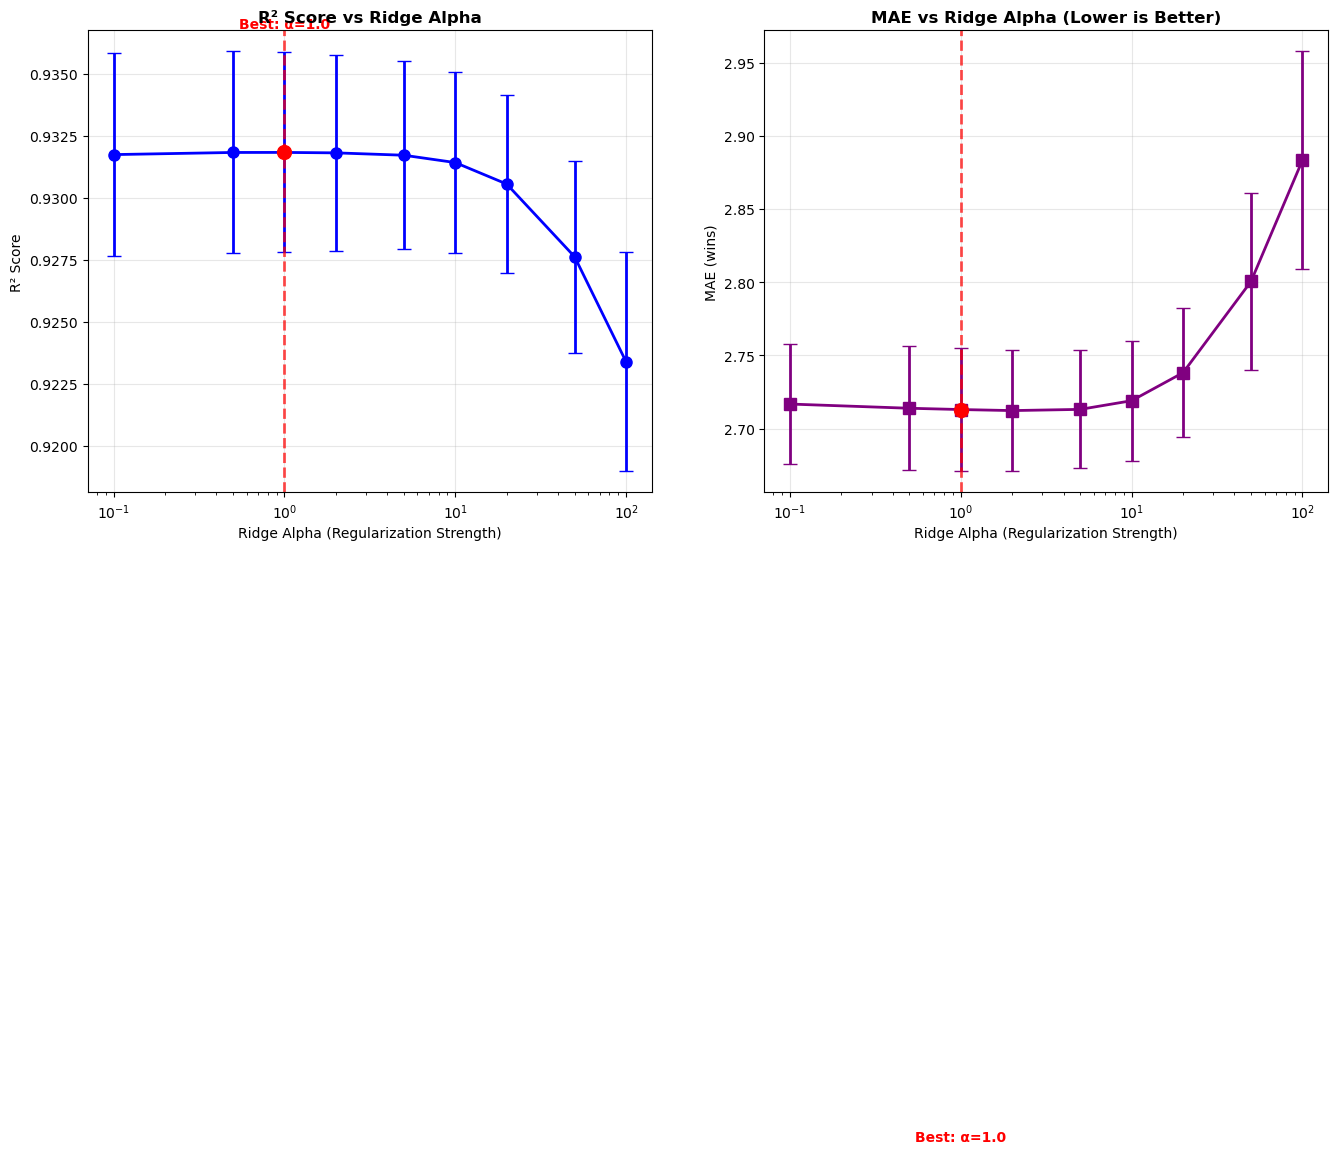


🔍 RIDGE REGULARIZATION ANALYSIS:
Best alpha: 1.0


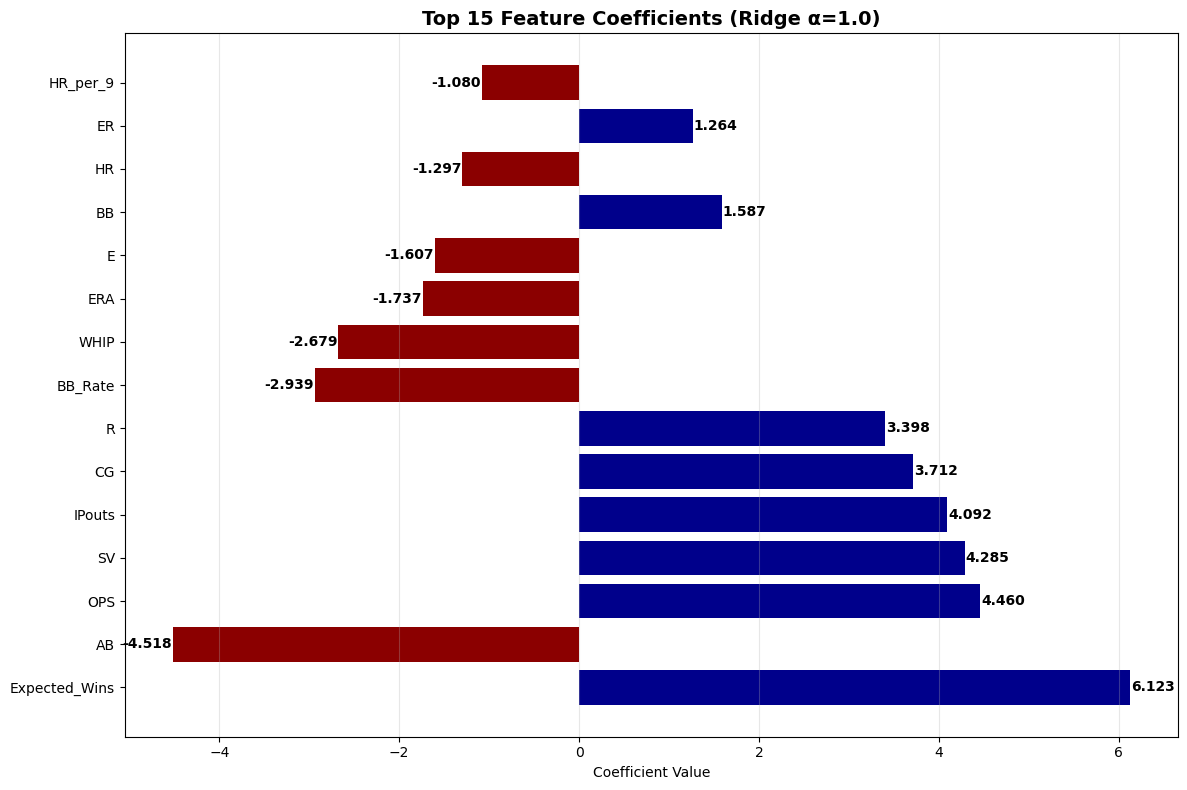


📊 REGULARIZATION STRENGTH ANALYSIS:
   α=  0.1: ||coefficients||₂ = 18.800
   α=  1.0: ||coefficients||₂ = 13.180
   α= 10.0: ||coefficients||₂ = 10.793
   α=100.0: ||coefficients||₂ = 7.674

🎯 FINAL OPTIMIZED RIDGE MODEL:
   Best alpha: 1.0
   Expected CV R²: 0.9318
   Expected CV MAE: 2.71 wins

✅ Optimized Ridge model is ready for predictions!
   Ridge uses L2 regularization to shrink coefficients without zeroing them out.
   All 53 features are used, but with regularized weights.


In [14]:
# Create visualization of Ridge hyperparameter tuning results
print("RIDGE TUNING VISUALIZATION")
print("="*35)

# Create plots showing R² and MAE across different alpha values
alpha_values_ridge = param_grid_ridge['ridge__alpha']
r2_scores_ridge = []
mae_scores_ridge = []
r2_stds_ridge = []
mae_stds_ridge = []

for alpha_val in alpha_values_ridge:
    # Find the result for this alpha value
    mask = results_df_ridge['param_ridge__alpha'] == alpha_val
    if mask.any():
        r2_scores_ridge.append(results_df_ridge.loc[mask, 'mean_test_r2'].iloc[0])
        r2_stds_ridge.append(results_df_ridge.loc[mask, 'std_test_r2'].iloc[0])
        mae_scores_ridge.append(-results_df_ridge.loc[mask, 'mean_test_neg_mean_absolute_error'].iloc[0])
        mae_stds_ridge.append(results_df_ridge.loc[mask, 'std_test_neg_mean_absolute_error'].iloc[0])

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# R² vs Alpha plot
ax1.errorbar(alpha_values_ridge, r2_scores_ridge, yerr=r2_stds_ridge, marker='o', capsize=5, linewidth=2, markersize=8, color='blue')
ax1.set_xscale('log')
ax1.set_xlabel('Ridge Alpha (Regularization Strength)')
ax1.set_ylabel('R² Score')
ax1.set_title('R² Score vs Ridge Alpha', fontsize=12, weight='bold')
ax1.grid(True, alpha=0.3)

# Highlight best alpha
best_alpha_ridge = grid_search_ridge.best_params_['ridge__alpha']
best_r2_ridge = grid_search_ridge.best_score_
ax1.axvline(x=best_alpha_ridge, color='red', linestyle='--', alpha=0.7, linewidth=2)
ax1.scatter([best_alpha_ridge], [best_r2_ridge], color='red', s=100, zorder=5)
ax1.text(best_alpha_ridge, best_r2_ridge + 0.005, f'Best: α={best_alpha_ridge}', 
         ha='center', fontweight='bold', color='red')

# MAE vs Alpha plot
ax2.errorbar(alpha_values_ridge, mae_scores_ridge, yerr=mae_stds_ridge, marker='s', capsize=5, linewidth=2, markersize=8, color='purple')
ax2.set_xscale('log')
ax2.set_xlabel('Ridge Alpha (Regularization Strength)')
ax2.set_ylabel('MAE (wins)')
ax2.set_title('MAE vs Ridge Alpha (Lower is Better)', fontsize=12, weight='bold')
ax2.grid(True, alpha=0.3)

# Highlight best alpha for MAE
best_mae_ridge = best_mae_score_ridge
ax2.axvline(x=best_alpha_ridge, color='red', linestyle='--', alpha=0.7, linewidth=2)
ax2.scatter([best_alpha_ridge], [best_mae_ridge], color='red', s=100, zorder=5)
ax2.text(best_alpha_ridge, best_mae_ridge - 0.5, f'Best: α={best_alpha_ridge}', 
         ha='center', fontweight='bold', color='red')

plt.tight_layout()
plt.show()

# Feature coefficient magnitude visualization
print(f"\n🔍 RIDGE REGULARIZATION ANALYSIS:")
print(f"Best alpha: {best_alpha_ridge}")

# Create feature coefficient plot (Ridge doesn't zero out features, but shrinks them)
top_features_ridge = feature_importance_ridge.head(15)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(top_features_ridge)), top_features_ridge['coefficient'], 
                color=['darkblue' if x > 0 else 'darkred' for x in top_features_ridge['coefficient']])
plt.yticks(range(len(top_features_ridge)), top_features_ridge['feature'])
plt.xlabel('Coefficient Value')
plt.title(f'Top 15 Feature Coefficients (Ridge α={best_alpha_ridge})', fontsize=14, weight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, coef) in enumerate(zip(bars, top_features_ridge['coefficient'])):
    plt.text(coef + (0.01 if coef > 0 else -0.01), i, f'{coef:.3f}', 
             ha='left' if coef > 0 else 'right', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Compare regularization strengths across different alpha values
print(f"\n📊 REGULARIZATION STRENGTH ANALYSIS:")
alpha_comparison = [0.1, 1.0, 10.0, 100.0]
ridge_norms = []

for alpha_comp in alpha_comparison:
    if alpha_comp in alpha_values_ridge:
        # Create temporary ridge with this alpha
        temp_ridge = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha_comp))
        ])
        temp_ridge.fit(X_full, y_full)
        coef_norm = np.linalg.norm(temp_ridge.named_steps['ridge'].coef_)
        ridge_norms.append(coef_norm)
        print(f"   α={alpha_comp:>5}: ||coefficients||₂ = {coef_norm:.3f}")

# Create the final optimized Ridge model
print(f"\n🎯 FINAL OPTIMIZED RIDGE MODEL:")
print(f"   Best alpha: {best_alpha_ridge}")
print(f"   Expected CV R²: {grid_search_ridge.best_score_:.4f}")
print(f"   Expected CV MAE: {best_mae_score_ridge:.2f} wins")

optimized_ridge_final = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=best_alpha_ridge))
])

# Train on full dataset
optimized_ridge_final.fit(X_full, y_full)

print(f"\n✅ Optimized Ridge model is ready for predictions!")
print(f"   Ridge uses L2 regularization to shrink coefficients without zeroing them out.")
print(f"   All {len(available_features)} features are used, but with regularized weights.")

In [ ]:
print("GENERATING FINAL PREDICTIONS WITH TUNED RIDGE")
print("="*50)

# Use the optimized Ridge model for final predictions
print(f"Using optimized model: Ridge with α={grid_search_ridge.best_params_['ridge__alpha']}")

# The optimized_ridge_final model is already trained on the full dataset
# Generate predictions on the test set
test_predictions_ridge = optimized_ridge_final.predict(X_test_final)

print(f"\nGenerated {len(test_predictions_ridge)} predictions for the test set")
print(f"Prediction range: {test_predictions_ridge.min():.2f} to {test_predictions_ridge.max():.2f} wins")
print(f"Prediction mean: {test_predictions_ridge.mean():.2f} wins")
print(f"Prediction std: {test_predictions_ridge.std():.2f} wins")

# Create submission dataframe
submission_df_ridge = pd.DataFrame({
    'ID': test_df['ID'],
    'W': test_predictions_ridge
})

print(f"\nSubmission dataframe shape: {submission_df_ridge.shape}")
print("First few predictions:")
print(submission_df_ridge.head(10))

print("\nLast few predictions:")
print(submission_df_ridge.tail(5))

# Verify no missing values
print(f"\nData validation:")
print(f"Missing values in ID: {submission_df_ridge['ID'].isnull().sum()}")
print(f"Missing values in W: {submission_df_ridge['W'].isnull().sum()}")
print(f"Unique IDs: {submission_df_ridge['ID'].nunique()}")

# Model summary for reference
print(f"\n🎯 FINAL MODEL SUMMARY:")
print(f"   Model: Tuned Ridge Regression with L2 Regularization")
print(f"   Ridge alpha: {grid_search_ridge.best_params_['ridge__alpha']}")
print(f"   Expected CV R²: {grid_search_ridge.best_score_:.4f}")
print(f"   Expected CV MAE: {best_mae_score_ridge:.2f} wins")
print(f"   Features: All {len(available_features)} features used (L2 regularization shrinks but doesn't eliminate)")

# Compare with training set statistics for sanity check
print(f"\n📊 PREDICTION SANITY CHECK:")
print(f"   Training W range: {y_full.min():.1f} to {y_full.max():.1f} wins")
print(f"   Training W mean: {y_full.mean():.1f} wins")
print(f"   Prediction range: {test_predictions_ridge.min():.1f} to {test_predictions_ridge.max():.1f} wins")
print(f"   Prediction mean: {test_predictions_ridge.mean():.1f} wins")

# Save submission to CSV with timestamp
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
submission_filename_ridge = f'submission_tuned_ridge_alpha{grid_search_ridge.best_params_["ridge__alpha"]}_{timestamp}.csv'
submission_path_ridge = SUB_DIR / submission_filename_ridge
submission_df_ridge.to_csv(submission_path_ridge, index=False)

print(f"\n💾 SUBMISSION SAVED:")
print(f"   Path: {submission_path_ridge}")
print(f"   Filename: {submission_filename_ridge}")
print(f"   Ready for Kaggle submission!")

# Final feature importance summary for Ridge
print(f"\n🏆 TOP FEATURES BY COEFFICIENT MAGNITUDE (RIDGE):")
top_features_ridge_final = feature_importance_ridge.head(10)
print("-" * 50)
for i, row in top_features_ridge_final.iterrows():
    print(f"   {row['feature']:>25}: {row['coefficient']:>7.3f}")

print(f"\n✅ TUNED RIDGE MODEL COMPLETE!")
print(f"   • L2 regularization shrinks all coefficients smoothly")
print(f"   • All {len(available_features)} features retained with regularized weights")  
print(f"   • Submission file saved and ready for upload")

GENERATING FINAL PREDICTIONS WITH TUNED RIDGE
Using optimized model: Ridge with α=1.0

Generated 453 predictions for the test set
Prediction range: 44.74 to 109.98 wins
Prediction mean: 79.06 wins
Prediction std: 12.08 wins

Submission dataframe shape: (453, 2)
First few predictions:
     ID          W
0  1756  69.559691
1  1282  74.534157
2   351  84.688074
3   421  87.098338
4    57  93.073882
5  1557  97.654580
6   846  79.345919
7  1658  83.904091
8   112  72.513048
9  2075  83.590775

Last few predictions:
       ID          W
448   651  68.344664
449     9  68.039160
450  1518  99.958493
451  2101  81.287258
452   451  66.493721

Data validation:
Missing values in ID: 0
Missing values in W: 0
Unique IDs: 453

🎯 FINAL MODEL SUMMARY:
   Model: Tuned Ridge Regression with L2 Regularization
   Ridge alpha: 1.0
   Expected CV R²: 0.9318
   Expected CV MAE: 2.71 wins
   Features: All 53 features used (L2 regularization shrinks but doesn't eliminate)

📊 PREDICTION SANITY CHECK:
   Train